In [1]:
# ==========================================================
# 0.  Библиотеки
# ----------------------------------------------------------
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import weibull_min, lognorm
from sklearn.neighbors import NearestNeighbors
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from random import shuffle

# ==========================================================
# 1.  Константы и «глобальные» настройки эксперимента
# ----------------------------------------------------------
n = 40
shape_weib = 0.5
mu_lognorm = 0.0
param_grid_H0 = {'λ': [0.001, 0.25, 0.5, 0.75, 1, 2.5, 5]}
param_grid_H1 = {'σ': [0.001, 0.25, 0.5, 0.75, 1, 2.5, 5]}
M = 1000
k_default = 5
d_factor = 1
rng = np.random.default_rng(seed=42)

# ==========================================================
# 2.  Генерация выборок
# ----------------------------------------------------------
def sample_weibull(n, lam, kappa=shape_weib, rng=rng):
    return weibull_min.rvs(c=kappa, scale=lam, size=n, random_state=rng)

def sample_lognorm(n, sigma, mu=mu_lognorm, rng=rng):
    return lognorm.rvs(s=sigma, scale=np.exp(mu), size=n, random_state=rng)

# ==========================================================
# 3.  Построение графов
# ----------------------------------------------------------
def build_knn_graph(sample, k=k_default):
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='euclidean').fit(sample.reshape(-1, 1))
    indices = nbrs.kneighbors(return_distance=False)[:, 1:]  # Exclude self-neighbor
    G = nx.Graph()
    edges = [(i, j) for i in range(len(sample)) for j in indices[i] if i < j]
    G.add_edges_from(edges)
    return G

def build_distance_graph(sample, d):
    n = len(sample)
    G = nx.Graph()
    sorted_sample = np.sort(sample)
    for i in range(n):
        for j in range(i + 1, n):
            if sorted_sample[j] - sorted_sample[i] <= d:
                G.add_edge(i, j)
            else:
                break  # Optimization for sorted data
    return G

# ==========================================================
# 4.  Числовые характеристики графов
# ----------------------------------------------------------
def triangle_count(G):
    return sum(nx.triangles(G).values()) // 3

def clique_number(G):
    return max(len(c) for c in nx.find_cliques(G))

# ==========================================================
# 5.  Monte‑Carlo‑циклы
# ----------------------------------------------------------


In [2]:
records = []

# --- 5.1  H0: Weibull -------------------------------------
for lam in tqdm(param_grid_H0['λ'], desc='H₀: Weibull λ'):
    for _ in range(M):
        x = sample_weibull(n, lam)
        # KNN‑граф
        G_knn = build_knn_graph(x)
        t_val = triangle_count(G_knn)
        # distance‑граф
        med_dist = np.median(np.abs(x.reshape(-1, 1) - x))
        d_emp = d_factor * med_dist
        G_dist = build_distance_graph(x, d=d_emp)
        w_val = clique_number(G_dist)

        records.extend([
            {'hyp': 'H0', 'param': lam, 'graph': 'knn', 'stat': 't', 'value': t_val},
            {'hyp': 'H0', 'param': lam, 'graph': 'dist', 'stat': 'omega', 'value': w_val}
        ])

# --- 5.2  H1: LogNormal -----------------------------------
for sigma in tqdm(param_grid_H1['σ'], desc='H₁: LogNormal σ'):
    for _ in range(M):
        x = sample_lognorm(n, sigma)
        G_knn = build_knn_graph(x)
        t_val = triangle_count(G_knn)

        med_dist = np.median(np.abs(x.reshape(-1, 1) - x))
        d_emp = d_factor * med_dist
        G_dist = build_distance_graph(x, d=d_emp)
        w_val = clique_number(G_dist)
        records.extend([
            {'hyp': 'H1', 'param': sigma, 'graph': 'knn', 'stat': 't', 'value': t_val},
            {'hyp': 'H1', 'param': sigma, 'graph': 'dist', 'stat': 'omega', 'value': w_val}
        ])

# ==========================================================
# 6.  Сводим в DataFrame и считаем агрегаты
# ----------------------------------------------------------
df = pd.DataFrame(records)

summary = df.groupby(['hyp', 'param', 'graph', 'stat'])['value'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'E[T]', 'std': 'SD[T]'})
print(summary)

H₀: Weibull λ:   0%|          | 0/7 [00:00<?, ?it/s]

H₁: LogNormal σ:   0%|          | 0/7 [00:00<?, ?it/s]

   hyp  param graph   stat    E[T]      SD[T]
0   H0  0.001  dist  omega  24.992   1.195561
1   H0  0.001   knn      t  72.450  11.170599
2   H0  0.250  dist  omega  24.959   1.309593
3   H0  0.250   knn      t  71.594  11.128477
4   H0  0.500  dist  omega  25.077   1.225795
5   H0  0.500   knn      t  72.383  11.165885
6   H0  0.750  dist  omega  25.035   1.221994
7   H0  0.750   knn      t  72.427  10.876993
8   H0  1.000  dist  omega  25.123   1.192180
9   H0  1.000   knn      t  72.246  11.364270
10  H0  2.500  dist  omega  24.985   1.275304
11  H0  2.500   knn      t  72.078  11.006319
12  H0  5.000  dist  omega  24.994   1.305246
13  H0  5.000   knn      t  72.154  11.313721
14  H1  0.001  dist  omega  17.381   1.462182
15  H1  0.001   knn      t  69.346  11.223915
16  H1  0.250  dist  omega  17.806   1.524693
17  H1  0.250   knn      t  69.859  11.681077
18  H1  0.500  dist  omega  18.388   1.536821
19  H1  0.500   knn      t  69.974  11.355451
20  H1  0.750  dist  omega  19.501

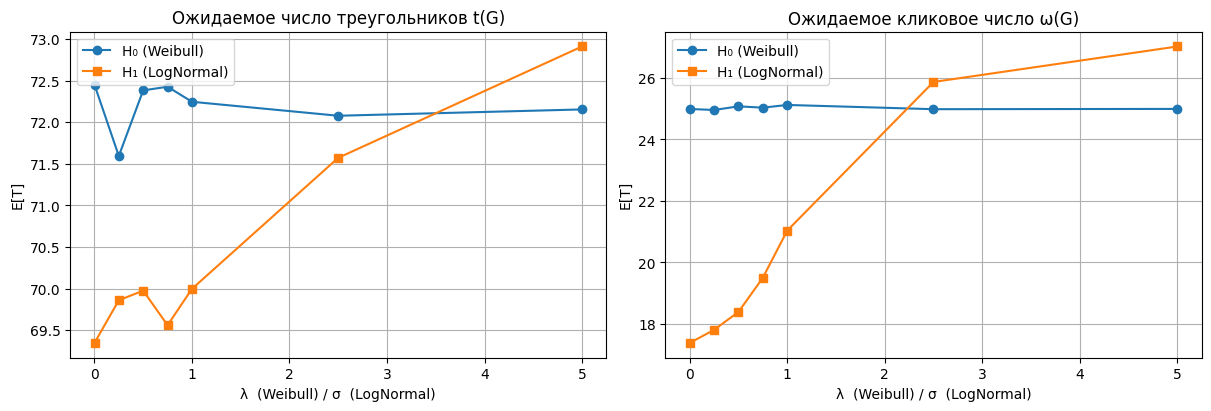

In [3]:
# ==========================================================
# 7.  Визуализация
# ----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# 7.1  t(G) на KNN‑графах
ax = axes[0]
sub = summary.query("graph=='knn'")
ax.plot(sub.loc[sub.hyp == 'H0', 'param'],
        sub.loc[sub.hyp == 'H0', 'E[T]'],
        marker='o', label='H₀ (Weibull)')
ax.plot(sub.loc[sub.hyp == 'H1', 'param'],
        sub.loc[sub.hyp == 'H1', 'E[T]'],
        marker='s', label='H₁ (LogNormal)')
ax.set_title("Ожидаемое число треугольников t(G)")
ax.set_xlabel("λ  (Weibull) / σ  (LogNormal)")
ax.set_ylabel("E[T]")
ax.grid(True)
ax.legend()

# 7.2  ω(G) на distance‑графах
ax = axes[1]
sub = summary.query("graph=='dist'")
ax.plot(sub.loc[sub.hyp == 'H0', 'param'],
        sub.loc[sub.hyp == 'H0', 'E[T]'],
        marker='o', label='H₀ (Weibull)')
ax.plot(sub.loc[sub.hyp == 'H1', 'param'],
        sub.loc[sub.hyp == 'H1', 'E[T]'],
        marker='s', label='H₁ (LogNormal)')
ax.set_title("Ожидаемое кликовое число ω(G)")
ax.set_xlabel("λ  (Weibull) / σ  (LogNormal)")
ax.set_ylabel("E[T]")
ax.grid(True)
ax.legend()

plt.show()


In [4]:
# --- базовые значения параметров распределений
shape_weib   = 0.5          # kappa
lam0         = 1.0          # θ0  (Weibull scale)
mu_lognorm   = 0.0
sigma0       = np.log(5)    # ν0  (LogNormal sigma)

# --- исследуемые размеры выборки
n_values     = [30, 50, 100, 200]

# --- сетка параметров графов
k_values     = [2, 4, 6, 8]     # для KNN
d_factors    = [0.2, 0.4, 0.6, 0.8, 1, 2] # доля медианного расстояния

# --- прочее
M            = 500           # прогонов Монте-Карло на точку (поднимайте при нужде)
rng          = np.random.default_rng(1)  # общий ГСЧ

# ==========================================================
# 3.  Основной Monte-Carlo
# ----------------------------------------------------------
records = []

for n in tqdm(n_values, desc="Размер выборки n"):
    # --- сначала KNN-графы (треугольники)
    for k in k_values:
        for _ in range(M):
            # H0 ••• Weibull
            x = sample_weibull(n, lam0)
            t = triangle_count(build_knn_graph(x, k))
            records.append({'hyp':'H0', 'n':n, 'param':k,
                            'graph':'knn', 'stat':'t', 'value':t})
            # H1 ••• LogNormal
            x = sample_lognorm(n, sigma0)
            t = triangle_count(build_knn_graph(x, k))
            records.append({'hyp':'H1', 'n':n, 'param':k,
                            'graph':'knn', 'stat':'t', 'value':t})
    # --- затем distance-графы (кликовое число)
    for d_factor in d_factors:
        for _ in range(M):
            # H0
            x = sample_weibull(n, lam0)
            d_thr = d_factor * np.median(np.abs(x.reshape(-1,1) - x))
            w = clique_number(build_distance_graph(x, d_thr))
            records.append({'hyp':'H0', 'n':n, 'param':d_factor,
                            'graph':'dist', 'stat':'omega', 'value':w})
            # H1
            x = sample_lognorm(n, sigma0)
            d_thr = d_factor * np.median(np.abs(x.reshape(-1,1) - x))
            w = clique_number(build_distance_graph(x, d_thr))
            records.append({'hyp':'H1', 'n':n, 'param':d_factor,
                            'graph':'dist', 'stat':'omega', 'value':w})

df = pd.DataFrame(records)

# ==========================================================
# 4.  Агрегируем результаты
# ----------------------------------------------------------
summary = (df
           .groupby(['hyp','n','graph','stat','param'])
           .value.agg(['mean','std'])
           .rename(columns={'mean':'E[T]','std':'SD[T]'})
           .reset_index())
summary.head()


Размер выборки n:   0%|          | 0/4 [00:00<?, ?it/s]

,hyp,n,graph,stat,param,E[T],SD[T]
0,H0,30,dist,omega,0.2,10.820,2.341488
1,H0,30,dist,omega,0.4,13.962,2.188638
2,H0,30,dist,omega,0.6,15.972,1.802697
3,H0,30,dist,omega,0.8,17.530,1.613166
4,H0,30,dist,omega,1.0,18.634,1.028669


In [5]:
import numpy as np
import pandas as pd          # только если нужно подправить summary
import plotly.graph_objects as go
import plotly.io as pio

import plotly.io as pio
pio.renderers.default = "browser"          # или fig.show(renderer="browser")


def plot_surface_pair_interactive(
        summary, *, graph='knn', stat='t',
        cmap_H0='Viridis', color_H1='crimson',
        elev=25, azim=35):
    """
    Рисуем две E[T]-поверхности в одном Plotly-окне:
        • H0 — гладкая полу-прозрачная
        • H1 — «псевдо-wireframe» (поверхность + контуры)
    Манипулировать мышью можно сразу после появления графика.
    """
    title_map = {'t': 't(G) — треугольники', 'omega': 'ω(G) — кликовое число'}
    ylabel    = 'k' if graph == 'knn' else 'd-factor'

    # --------------------------------------------------- собираем данные
    data = {}
    for hyp in ('H0', 'H1'):
        sub = (summary
               .loc[(summary.hyp == hyp) &
                    (summary.graph == graph) &
                    (summary.stat == stat)]
               .copy())
        n_vals     = sorted(sub.n.unique())
        param_vals = sorted(sub.param.unique())
        X, Y = np.meshgrid(n_vals, param_vals)
        Z = (sub
             .pivot(index='param', columns='n', values='E[T]')
             .loc[param_vals, n_vals]
             .values)
        data[hyp] = dict(X=X, Y=Y, Z=Z)

    # --------------------------------------------------- строим Plotly-фигуру
    fig = go.Figure()

    # H0 — гладкая полупрозрачная поверхность
    fig.add_surface(
        x=data['H0']['X'], y=data['H0']['Y'], z=data['H0']['Z'],
        colorscale=cmap_H0, opacity=0.80,
        name='H₀ (Weibull)', showscale=False
    )

    # H1 — контурная «сеткой»; сама поверхность почти прозрачная
    fig.add_surface(
        x=data['H1']['X'], y=data['H1']['Y'], z=data['H1']['Z'],
        colorscale=[[0, color_H1], [1, color_H1]],
        opacity=0.05, showscale=False, name='H₁ (LogNormal)',
        contours=dict(
            x=dict(show=True, color=color_H1, width=1),
            y=dict(show=True, color=color_H1, width=1),
            z=dict(show=True, color=color_H1, width=1)
        )
    )

    # --------------------------------------------------- оформление
    # преобразуем углы (elev, azim) в положение «камеры» Plotly
    import math
    elev_rad, azim_rad = math.radians(elev), math.radians(azim)
    camera_eye = dict(
        x=2 * math.cos(azim_rad) * math.cos(elev_rad),
        y=2 * math.sin(azim_rad) * math.cos(elev_rad),
        z=2 * math.sin(elev_rad)
    )

    fig.update_layout(
        title=dict(
            text=f"{title_map.get(stat, stat)}<br>"
                 f"{'KNN' if graph == 'knn' else 'distance'}-граф  "
                 "(H₀ — поверхность, H₁ — сетка)",
            x=0.5, y=0.9
        ),
        scene=dict(
            xaxis_title='n',
            yaxis_title=ylabel,
            zaxis_title='E[T]',
            camera=dict(eye=camera_eye)
        ),
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )

    fig.show()

plot_surface_pair_interactive(summary, graph='knn',  stat='t')
plot_surface_pair_interactive(summary, graph='dist', stat='omega')


In [12]:
# =============================================================
# 0.  Импорт и базовые параметры (из предыдущих ячеек / по умолч.)
# -------------------------------------------------------------
import numpy as np, pandas as pd, networkx as nx
from scipy.stats import weibull_min, lognorm
from sklearn.neighbors import NearestNeighbors
from random import shuffle
from collections import Counter

rng = np.random.default_rng(123)

# --- параметры распределений (фиксированные θ0, ν0)
shape_weib, lam0 = 0.5, 1.0          # H0
mu_lognorm, sigma0 = 0.0, np.log(5)  # H1

# --- параметры графа и выборки
n          = 250        # размер выборки
k_knn      = 5          # для KNN
d_factor   = 1        # для distance
M0 = 1000         # симуляций под H0
M1 = 1000            # симуляций под H1
alpha      = 0.05       # допустимая ошибка I рода

# =============================================================
# 1.  Функции генерации и статистики  (как прежде, но короче)
# -------------------------------------------------------------
def sample_weibull(n, lam):   return weibull_min.rvs(c=shape_weib, scale=lam, size=n, random_state=rng)
def sample_lognorm(n, sig):  return lognorm.rvs(s=sig, scale=np.exp(mu_lognorm), size=n, random_state=rng)

# =============================================================
# 2.  Однократный прогон → значение статистики
# -------------------------------------------------------------
def draw_T(stat='t'):
    """Возвращает пару (T_H0, T_H1) для выбранной статистики"""
    x0 = sample_weibull(n, lam0)
    x1 = sample_lognorm(n, sigma0)

    if stat == 't':                         # KNN-граф
        G0 = build_knn_graph(x0, k_knn)
        G1 = build_knn_graph(x1, k_knn)
        return triangle_count(G0), triangle_count(G1)
    elif stat == 'omega':                   # distance-граф
        d0 = d_factor * np.median(np.abs(x0.reshape(-1,1)-x0))
        d1 = d_factor * np.median(np.abs(x1.reshape(-1,1)-x1))
        G0 = build_distance_graph(x0, d0)
        G1 = build_distance_graph(x1, d1)
        return clique_number(G0), clique_number(G1)
    else:
        raise ValueError("stat ∈ {'t', 'omega'}")

# =============================================================
# 3.  Собираем эмпирические выборки T|H0 и T|H1
# -------------------------------------------------------------
def simulate_T_samples(stat='t'):
    T0, T1 = [], []
    for _ in range(M0):
        t0, _ = draw_T(stat)
        T0.append(t0)
    for _ in range(M1):
        _, t1 = draw_T(stat)
        T1.append(t1)
    return np.array(T0), np.array(T1)

# =============================================================
# 4.  Оптимальный (по частотам) критерий уровня α
# -------------------------------------------------------------
def build_critical_region(T0, T1, alpha=alpha):
    """Возвращает set(reject_values)  и эмпирические (alphâ, power̂)"""
    # частоты
    f0 = Counter(T0);  f1 = Counter(T1)
    n0, n1 = len(T0), len(T1)

    # относительные частоты
    vals = sorted(set(f0)|set(f1))
    table = pd.DataFrame({
        't':   vals,
        'p0':  [f0[v]/n0 for v in vals],
        'p1':  [f1[v]/n1 for v in vals]
    })
    table['lr'] = table.p1 / (table.p0 + 1e-12)   # эмп. отношение правдоподобия

    # сортируем по убыванию lr (NP-критерий) и накапливаем p0
    table = table.sort_values('lr', ascending=False).reset_index(drop=True)
    table['cum_p0'] = table.p0.cumsum()

    reject = set()
    for _, row in table.iterrows():
        if row.cum_p0 <= alpha:
            reject.add(row.t)
        else:
            break
    # факт. ошибки и мощность
    alpha_hat  = table.loc[table.t.isin(reject), 'p0'].sum()
    power_hat  = table.loc[table.t.isin(reject), 'p1'].sum()
    return reject, alpha_hat, power_hat, table

# =============================================================
# 5.  Запускаем для t(G)  и ω(G)
# -------------------------------------------------------------
results = {}
for stat in ['t', 'omega']:
    T0, T1 = simulate_T_samples(stat)
    R, alpha_emp, power_emp, tbl = build_critical_region(T0, T1)
    results[stat] = dict(reject=R, alpha=alpha_emp, power=power_emp, table=tbl)

# =============================================================
# 6.  Вывод
# -------------------------------------------------------------
for stat, res in results.items():
    name = "t(G) — треугольники" if stat=='t' else "ω(G) — кликовое число"
    print(f"\n=== {name} ===")
    print(f"Размер выборки n = {n:3d}, "
          f"{'k='+str(k_knn) if stat=='t' else 'd_factor='+str(d_factor)}")
    print(f"Число уникальных значений T   : {len(res['table'])}")
    print(f"Критическая область |R|       : {len(res['reject'])} значений")
    print(f"Эмпирическая ошибка I рода    : {res['alpha']:.4f}")
    print(f"Эмпирическая мощность         : {res['power']:.4f}")



=== t(G) — треугольники ===
Размер выборки n = 250, k=5
Число уникальных значений T   : 155
Критическая область |R|       : 30 значений
Эмпирическая ошибка I рода    : 0.0440
Эмпирическая мощность         : 0.1240

=== ω(G) — кликовое число ===
Размер выборки n = 250, d_factor=1
Число уникальных значений T   : 31
Критическая область |R|       : 17 значений
Эмпирическая ошибка I рода    : 0.0440
Эмпирическая мощность         : 0.7290


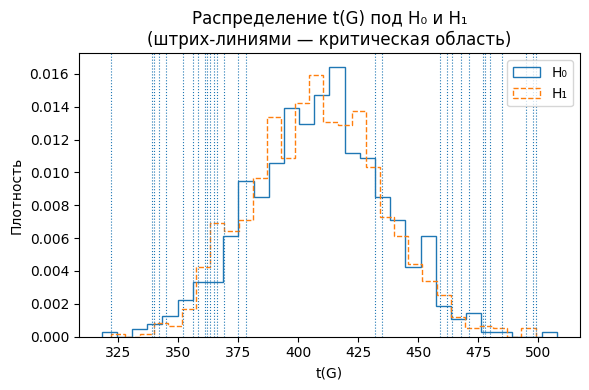

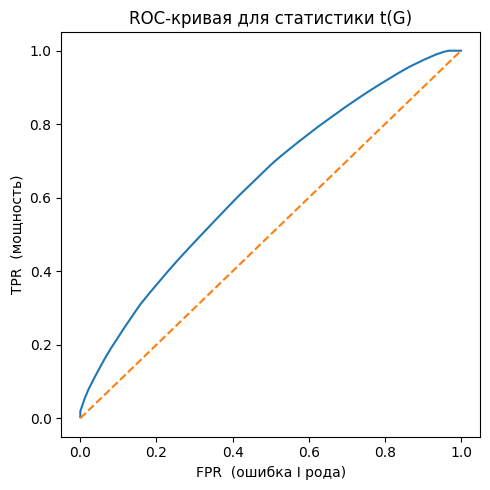

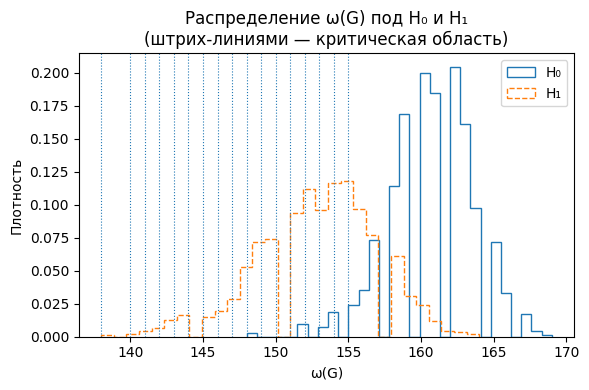

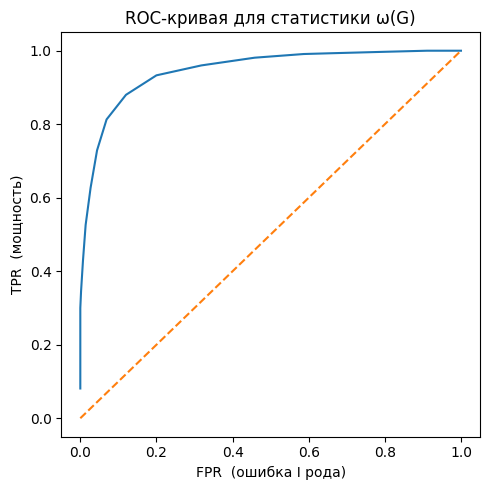

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helper: get simulation & NP-table again if not present ----------
try:
    results
except NameError:
    raise RuntimeError("Запустите предварительную ячейку, которая формирует объект 'results'.")

# ---------- 1.  Histogram-overlay для каждой статистики ---------------------
def plot_histograms(stat_key, bins=30):
    """
    Overlay two histograms (density) of T under H0 / H1.
    Also marks values из критической области R as вертикальные линии.
    """
    name = "t(G)" if stat_key == 't' else "ω(G)"
    R    = results[stat_key]['reject']
    tbl  = results[stat_key]['table']

    # восстановим массивы T0, T1 из таблицы частотц
    T0_vals = np.repeat(tbl['t'].values, (tbl['p0'] * 10000).round().astype(int))
    T1_vals = np.repeat(tbl['t'].values, (tbl['p1'] * 10000).round().astype(int))

    plt.figure(figsize=(6,4))
    plt.hist(T0_vals, bins=bins, density=True, histtype='step', label='H₀')
    plt.hist(T1_vals, bins=bins, density=True, histtype='step', label='H₁', linestyle='dashed')
    ymin, ymax = plt.ylim()

    # вертикальные линии для критической области
    for t in sorted(R):
        plt.vlines(t, ymin, ymax, linestyle='dotted', linewidth=0.8)

    plt.title(f"Распределение {name} под H₀ и H₁\n(штрих-линиями — критическая область)")
    plt.xlabel(name)
    plt.ylabel("Плотность")
    plt.legend()
    plt.ylim(ymin, ymax)
    plt.tight_layout()
    plt.show()

# ---------- 2.  ROC-кривая --------------------------------------------------
def plot_roc(stat_key):
    tbl = results[stat_key]['table'].sort_values('lr', ascending=False)
    tbl['FPR'] = tbl['p0'].cumsum()        # ошибка I рода (α)
    tbl['TPR'] = tbl['p1'].cumsum()        # мощность (1−β)

    plt.figure(figsize=(5,5))
    plt.plot(tbl['FPR'], tbl['TPR'])
    plt.plot([0,1], [0,1], linestyle='dashed')   # диагональ случайного угадывания
    plt.title(f"ROC-кривая для статистики "
              f"{'t(G)' if stat_key=='t' else 'ω(G)'}")
    plt.xlabel("FPR  (ошибка I рода)")
    plt.ylabel("TPR  (мощность)")
    plt.tight_layout()
    plt.show()

# ---------- 3.  Запуск для обеих статистик ---------------------------------
for key in ['t', 'omega']:
    plot_histograms(key)
    plot_roc(key)


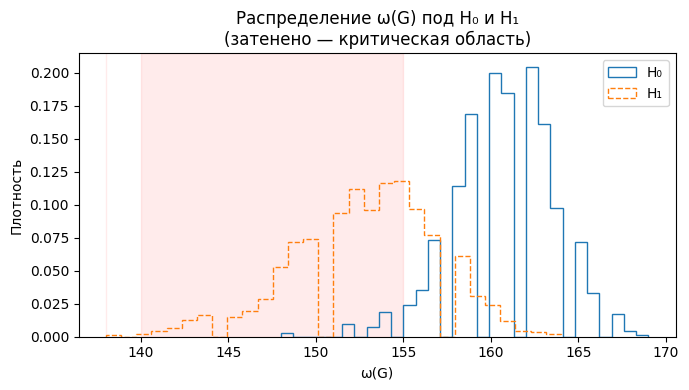

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram_with_reject(stat_key='omega', bins=30):
    name = "ω(G)" if stat_key=='omega' else "t(G)"
    tbl  = results[stat_key]['table']
    R    = sorted(results[stat_key]['reject'])

    # --- целевые данные для рисования -----------------------
    # аккуратно восстанавливаем массивы, чтобы плотности были гладкими
    scale = 20000           # масштаб для повторений
    T0 = np.repeat(tbl['t'], (tbl['p0']*scale).round().astype(int))
    T1 = np.repeat(tbl['t'], (tbl['p1']*scale).round().astype(int))

    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(T0, bins=bins, density=True, histtype='step', label='H₀')
    ax.hist(T1, bins=bins, density=True, histtype='step', linestyle='--', label='H₁')
    ax.set_xlabel(name); ax.set_ylabel("Плотность")
    ax.set_title(f"Распределение {name} под H₀ и H₁\n(затенено — критическая область)")

    # --- строим интервалы из R -------------------------------------------
    # группируем соседние целые t в непрерывные отрезки
    intervals = []
    start = prev = R[0]
    for t in R[1:]:
        if t == prev + 1:
            prev = t
        else:
            intervals.append((start, prev))
            start = prev = t
    intervals.append((start, prev))

    # --- если область одна и «тянется влево», покажем одну границу --------
    if len(intervals) == 1 and intervals[0][1] < min(tbl['t']):
        ax.axvline(intervals[0][1], color='red', linestyle=':', label='граница α=0.05')
        ax.fill_betweenx([0, ax.get_ylim()[1]], tbl['t'].min(), intervals[0][1],
                         alpha=0.1, color='red')
    else:
        # иначе подсвечиваем каждый интервал
        ymax = ax.get_ylim()[1]
        for a, b in intervals:
            ax.fill_betweenx([0, ymax], a, b, alpha=0.08, color='red')
        ax.set_ylim(top=ymax)

    ax.legend()
    plt.tight_layout()
    plt.show()

plot_histogram_with_reject('omega')   # вызов для ω(G)
